# 獲取句尾字列表並轉換成《廣韻》韻目列表

In [1]:
import requests
import pandas as pd

In [2]:
# 獲取唐朝詩人列表
dynasty = "唐朝" # 分批次輸入"隋朝""唐朝"
url = f"https://open.cnkgraph.com/api/Writing/{dynasty}"
headers = {"Accept-Language": "zh-hant"}
response = requests.get(url, headers=headers)
if response.status_code == 200:
    data = response.json()
    sub_dynasties = data.get('AuthorsByDynasty',{}).get('Dynasties',[])
    authors = []
    for sub_dynasty in sub_dynasties:
        filter_condition = sub_dynasty['Name'] in ['隋末唐初', '初唐', '武周','唐','盛唐','中唐','晚唐'] #隋朝設置爲in ['隋']，唐朝設置爲in ['隋末唐初', '初唐', '武周','唐','盛唐','中唐','晚唐']
        if filter_condition:
            author_dic_list = sub_dynasty['Authors']
            for author_dic in author_dic_list:
                authors.append(author_dic['Name'])
else:
    print(f"请求失败，状态码: {response.status_code}")

In [5]:
#獲取指定詩人作品     
def get_data(dynasty,author,output_folder_path):
    pageNo = 0
    df = pd.DataFrame(columns=['作者', '標題', '小標題', '平水韻/詞林正韻', '句尾字'])
    get_writings(dynasty,author,pageNo,df)
    condition = df['句尾字'][0]
    pageNo += 1

    next_page = True
    while next_page:
        index = len(df)
        get_writings(dynasty,author,pageNo,df)
        try:
            item = df['句尾字'][index]
        except KeyError:
            break # 已到達數據末尾，跳出循環（此情況是總共的數據條數是20的整數倍）
        next_page = item != condition # 如果當前頁最先獲取的'句尾字'內容與第0頁獲取的第0條內容一致，則跳出循環（此情況是總共的數據條數不是20的整數倍）
        pageNo += 1

    df = df.drop(df.index[index:])
    
    process_data(df)
    
    file_path = output_folder_path + f'/{author}.xlsx'
    df.to_excel(file_path, index=False)

def get_writings(dynasty,author,pageNo,df):
    # df中的列要包括['作者', '標題', '小標題', '平水韻/詞林正韻', '句尾字']
    url = f"https://open.cnkgraph.com/api/Writing/{dynasty}/{author}?pageNo={pageNo}"
    headers = {"Accept-Language": "zh-hant"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        writings = data.get('Writings', [])
        for writing in writings:
            author = writing.get('Author', '')
            title = writing.get('Title', {}).get('Content', '')
            subtitle_dic = writing.get('SubTitle', {})
            if subtitle_dic:
                subtitle = subtitle_dic.get('Content', '')
            else:
                subtitle = ''
            rhyme = writing.get('Rhyme', '')
            clauses = writing.get('Clauses', [])
            items = [clause.get('Content', '')[-2] for clause in clauses] #僅針對一般情況，如果是先秦詩歌要排除“兮”的影響，改成[clause.get('Content', '')[-2] if clause.get('Content', '')[-2] != '兮' else clause.get('Content', '')[-3] for clause in clauses]
            df.loc[len(df)] = [author, title, subtitle, rhyme, items]
        return df
    else:
        print(f"獲取第{pageNo}頁請求失敗，狀態碼: {response.status_code}。")

def process_data(df):
    # 將韻字列表並轉換成《廣韻》韻目列表
    guangyun_df = pd.read_excel('广韵Excel版.xlsx')
    df['韻目列表（合併多音字）'] = [[] for _ in range(len(df))]
    df['韻目列表'] = [[] for _ in range(len(df))]
    for index, row in df.iterrows():
        yunmu_list = []
        yunmu_list2 = []
        for item in row['句尾字']:
            match = guangyun_df[guangyun_df['字目'].str.contains(item)]
            match_list = []
            for i, match_row in match.iterrows():
                yunmu_list2.append(match_row['韻目'])
                match_list.append(match_row['韻目'])
            match_str = '（' + ''.join(match_list) + '）'
            yunmu_list.append(match_str)
        df.at[index, '韻目列表（合併多音字）'] = yunmu_list
        df.at[index, '韻目列表'] = yunmu_list2

In [6]:
output_folder_path = r'F:\古籍處理數據\output\隋唐\作品'
for author in authors:
    print(f'正在獲取並處理“{author}”相關數據...')
    get_data(dynasty,author,output_folder_path)
    print(f'獲取並處理“{author}”相關數據成功！')

正在獲取並處理“唐备”相關數據...
獲取並處理“唐备”相關數據成功！
正在獲取並處理“高蟾”相關數據...
獲取並處理“高蟾”相關數據成功！
正在獲取並處理“張禕”相關數據...
獲取並處理“張禕”相關數據成功！
正在獲取並處理“陳蛻”相關數據...
獲取並處理“陳蛻”相關數據成功！
正在獲取並處理“王駕”相關數據...
獲取並處理“王駕”相關數據成功！
正在獲取並處理“錢珝”相關數據...
獲取並處理“錢珝”相關數據成功！
正在獲取並處理“張塋”相關數據...
獲取並處理“張塋”相關數據成功！
正在獲取並處理“蔣肱”相關數據...
獲取並處理“蔣肱”相關數據成功！
正在獲取並處理“戴司顏”相關數據...
獲取並處理“戴司顏”相關數據成功！
正在獲取並處理“張隱”相關數據...
獲取並處理“張隱”相關數據成功！
正在獲取並處理“孫定”相關數據...
獲取並處理“孫定”相關數據成功！
正在獲取並處理“孫偓”相關數據...
獲取並處理“孫偓”相關數據成功！
正在獲取並處理“褚載”相關數據...
獲取並處理“褚載”相關數據成功！
正在獲取並處理“唐廩”相關數據...
獲取並處理“唐廩”相關數據成功！
正在獲取並處理“颜荛”相關數據...
獲取並處理“颜荛”相關數據成功！
正在獲取並處理“张蠙”相關數據...
獲取並處理“张蠙”相關數據成功！
正在獲取並處理“黄蟾”相關數據...
獲取並處理“黄蟾”相關數據成功！
正在獲取並處理“刘望”相關數據...
獲取並處理“刘望”相關數據成功！
正在獲取並處理“拓善”相關數據...
獲取並處理“拓善”相關數據成功！
正在獲取並處理“怀浚”相關數據...
獲取並處理“怀浚”相關數據成功！
正在獲取並處理“鄭冠卿”相關數據...
獲取並處理“鄭冠卿”相關數據成功！
正在獲取並處理“崔江”相關數據...
獲取並處理“崔江”相關數據成功！
正在獲取並處理“汪極”相關數據...
獲取並處理“汪極”相關數據成功！
正在獲取並處理“文秀”相關數據...
獲取並處理“文秀”相關數據成功！
正在獲取並處理“鄭準”相關數據...
獲取並處理“鄭準”相關數據成功！
正在獲取並處理“薛昭緯”相關數據...
獲取並處理“薛昭緯”相關數據成功！
正在獲取並處理“朱著”相關數據...
獲取並處理“朱著”相關數據成功！
正在獲取並處理“蘇拯”相關數據...
獲取並

獲取並處理“歐陽詹”相關數據成功！
正在獲取並處理“王仲舒”相關數據...
獲取並處理“王仲舒”相關數據成功！
正在獲取並處理“駱浚”相關數據...
獲取並處理“駱浚”相關數據成功！
正在獲取並處理“宇文融”相關數據...
獲取並處理“宇文融”相關數據成功！
正在獲取並處理“楊凝”相關數據...
獲取並處理“楊凝”相關數據成功！
正在獲取並處理“羊士諤”相關數據...
獲取並處理“羊士諤”相關數據成功！
正在獲取並處理“成輔端”相關數據...
獲取並處理“成輔端”相關數據成功！
正在獲取並處理“李絳”相關數據...
獲取並處理“李絳”相關數據成功！
正在獲取並處理“潘孟陽”相關數據...
獲取並處理“潘孟陽”相關數據成功！
正在獲取並處理“柳公綽”相關數據...
獲取並處理“柳公綽”相關數據成功！
正在獲取並處理“段弘古”相關數據...
獲取並處理“段弘古”相關數據成功！
正在獲取並處理“陸質”相關數據...
獲取並處理“陸質”相關數據成功！
正在獲取並處理“陸亘”相關數據...
獲取並處理“陸亘”相關數據成功！
正在獲取並處理“于敖”相關數據...
獲取並處理“于敖”相關數據成功！
正在獲取並處理“王涯”相關數據...
獲取並處理“王涯”相關數據成功！
正在獲取並處理“薛少殷”相關數據...
獲取並處理“薛少殷”相關數據成功！
正在獲取並處理“裴度”相關數據...
獲取並處理“裴度”相關數據成功！
正在獲取並處理“薛存誠”相關數據...
獲取並處理“薛存誠”相關數據成功！
正在獲取並處理“令狐峘”相關數據...
獲取並處理“令狐峘”相關數據成功！
正在獲取並處理“陳京”相關數據...
獲取並處理“陳京”相關數據成功！
正在獲取並處理“令狐楚”相關數據...
獲取並處理“令狐楚”相關數據成功！
正在獲取並處理“李觀”相關數據...
獲取並處理“李觀”相關數據成功！
正在獲取並處理“李程”相關數據...
獲取並處理“李程”相關數據成功！
正在獲取並處理“盧景亮”相關數據...
獲取並處理“盧景亮”相關數據成功！
正在獲取並處理“樊宗師”相關數據...
獲取並處理“樊宗師”相關數據成功！
正在獲取並處理“張仲方”相關數據...
獲取並處理“張仲方”相關數據成功！
正在獲取並處理“元友讓”相關數據...
獲取並處理“元友讓”相關數據成功！
正在獲取並處理“羅讓”相關數據.

獲取並處理“郑殷彝”相關數據成功！
正在獲取並處理“王霞卿”相關數據...
獲取並處理“王霞卿”相關數據成功！
正在獲取並處理“文炬”相關數據...
獲取並處理“文炬”相關數據成功！
正在獲取並處理“玄泰”相關數據...
獲取並處理“玄泰”相關數據成功！
正在獲取並處理“子蘭”相關數據...
獲取並處理“子蘭”相關數據成功！
正在獲取並處理“舒道紀”相關數據...
獲取並處理“舒道紀”相關數據成功！
正在獲取並處理“王渙”相關數據...
獲取並處理“王渙”相關數據成功！
正在獲取並處理“鄭綮”相關數據...
獲取並處理“鄭綮”相關數據成功！
正在獲取並處理“魚又玄”相關數據...
獲取並處理“魚又玄”相關數據成功！
正在獲取並處理“徐彥若”相關數據...
獲取並處理“徐彥若”相關數據成功！
正在獲取並處理“洪諲”相關數據...
獲取並處理“洪諲”相關數據成功！
正在獲取並處理“蘇檢”相關數據...
獲取並處理“蘇檢”相關數據成功！
正在獲取並處理“尔朱翱”相關數據...
獲取並處理“尔朱翱”相關數據成功！
正在獲取並處理“吴融”相關數據...
獲取並處理“吴融”相關數據成功！
正在獲取並處理“張氏”相關數據...
獲取並處理“張氏”相關數據成功！
正在獲取並處理“张瑜”相關數據...
獲取並處理“张瑜”相關數據成功！
正在獲取並處理“张浚”相關數據...
獲取並處理“张浚”相關數據成功！
正在獲取並處理“崔远”相關數據...
獲取並處理“崔远”相關數據成功！
正在獲取並處理“趙崇”相關數據...
獲取並處理“趙崇”相關數據成功！
正在獲取並處理“裴贄”相關數據...
獲取並處理“裴贄”相關數據成功！
正在獲取並處理“吳公”相關數據...
獲取並處理“吳公”相關數據成功！
正在獲取並處理“唐求”相關數據...
獲取並處理“唐求”相關數據成功！
正在獲取並處理“張翱”相關數據...
獲取並處理“張翱”相關數據成功！
正在獲取並處理“鄭賨”相關數據...
獲取並處理“鄭賨”相關數據成功！
正在獲取並處理“鄭遨”相關數據...
獲取並處理“鄭遨”相關數據成功！
正在獲取並處理“李善夷”相關數據...
獲取並處理“李善夷”相關數據成功！
正在獲取並處理“李曄”相關數據...
獲取並處理“李曄”相關數據成功！
正在獲取並處理“裴廷裕”相關數據...
獲取並處理“裴廷裕”相關數據

# Apriori算法挖掘关联规则

In [7]:
import pandas as pd
import os
import ast
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [8]:
# 讀取數據
folder_path = r'F:\古籍處理數據\output\隋唐\作品'
dataframes = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        dataframes.append(df)
        
df_2 = pd.concat(dataframes, ignore_index=True)
df_2['韻目列表'] = df_2['韻目列表'].apply(ast.literal_eval)
df_2.head()

,作者,標題,小標題,平水韻/詞林正韻,句尾字,韻目列表（合併多音字）,韻目列表
0,□嘉惠,詠鵲,NaN,支,"['定', '期', '語', '時']","['（徑徑）', '（之）', '（語御）', '（之）']","[徑, 徑, 之, 語, 御, 之]"
1,□釗,沙門崇惠登刀梯歌,NaN,NaN,"['梯', '霓', '齋', '蜺', '樹', '山', '間', '登', '毛', ...","['（齊）', '（齊霽屑）', '（皆）', '（齊屑）', '（麌遇）', '（山）',...","[齊, 齊, 霽, 屑, 皆, 齊, 屑, 麌, 遇, 山, 襇, 登, 豪, 号, 刪, ..."
2,《南岳魏夫人传》所引诗,双礼珠弹云璈而答歌一章,NaN,5,"['天', '外', '峨', '翳', '华', '气', '咏', '慧', '景', ...","['（先）', '（泰）', '（）', '（齊霽）', '（）', '（未）', '（映）...","[先, 泰, 齊, 霽, 未, 映, 霽, 梗, 止, 泰, 泰, 至, 卦, 東, 送]"
3,《南岳魏夫人传》所引诗,高仙盼游洞灵之曲一章并序,NaN,NaN,"['霞', '晨', '目', '元', '中', '迁', '章', '篇', '内', ...","['（麻）', '（眞眞）', '（屋）', '（元）', '（東送）', '（先）', '...","[麻, 眞, 眞, 屋, 元, 東, 送, 先, 陽, 仙, 隊, 侵, 東]"
4,《南岳魏夫人传》所引诗,方诸青童歌一章,NaN,NaN,"['晖', '形', '外', '清', '袂', '生', '房', '冥', '子', ...","['（）', '（青）', '（泰）', '（清）', '（祭）', '（庚映）', '（陽...","[青, 泰, 清, 祭, 庚, 映, 陽, 唐, 青, 止, 清, 清, 霰, 先, 霰]"


In [9]:
# 將“韻目列表”變成集合，並轉換成one-hot編碼
yunmu_set = df_2['韻目列表'].apply(set)
yunmu_df = pd.DataFrame({'韻目集合':yunmu_set})
yunmu_df['韻目集合'] = yunmu_df['韻目集合'].apply(lambda x: ','.join(x))
dummy_df = yunmu_df['韻目集合'].str.get_dummies(',')
dummy_df = dummy_df.astype(bool)
dummy_df.head()

,之,乏,仙,代,佳,侯,侵,候,儼,元,...,魂,魚,鹽,麌,麥,麻,黝,黠,齊,𣕊
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,True,False,False,False,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# 獲取頻繁項集
frequent_itemsets = apriori(dummy_df, min_support=0.01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.111125,(之)
1,0.123962,(仙)
2,0.057083,(代)
3,0.014408,(佳)
4,0.047246,(侯)
...,...,...
1011,0.011674,"(語, 御, 送, 東)"
1012,0.010735,"(遇, 御, 語, 麌)"
1013,0.024960,"(唐, 宕, 映, 清, 庚)"
1014,0.010327,"(唐, 宕, 陽, 映, 庚)"


In [11]:
# 獲取關聯規則
rules_df = association_rules(frequent_itemsets, metric='confidence',min_threshold=0.6) # 用置信度篩選
rules_df = rules_df[rules_df['lift'] > 5] # 進一步用提升度篩選
rules_df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(脂),(之),0.064614,0.111125,0.041042,0.635186,5.715977,0.033861,2.436519,0.882044
2,(海),(代),0.052593,0.057083,0.033858,0.643772,11.277860,0.030856,2.646947,0.961921
3,(佳),(支),0.014408,0.108614,0.011817,0.820113,7.550683,0.010252,4.955261,0.880245
4,(佳),(麻),0.014408,0.058532,0.010245,0.711048,12.148064,0.009402,3.258218,0.931098
5,(侯),(尤),0.047246,0.087920,0.036899,0.780994,8.882985,0.032745,4.164625,0.931432


In [12]:
# 合併規則中的前提與結論，以便後匹配規則是否是“韻目集合”的子集
df_2['韻目集合'] = df_2['韻目列表'].map(frozenset) # 轉換成frozenset格式，以便進行集合運算
rules_df['rules'] = rules_df.apply(lambda row: frozenset.union(row['antecedents'], row['consequents']), axis=1)
rules_df = rules_df.drop_duplicates(subset='rules')

In [13]:
path = 'F:\古籍處理數據\output\隋唐\規則\總規則.xlsx'
rules_df.to_excel(path, index=False)

<>:1: DeprecationWarning: invalid escape sequence '\o'
<>:1: DeprecationWarning: invalid escape sequence '\o'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6044\14083500.py:1: DeprecationWarning: invalid escape sequence '\o'
  path = 'F:\古籍處理數據\output\隋唐\規則\總規則.xlsx'


In [14]:
# 規則匹配到相關的詩歌條目中
df_2['rules'] = [[] for _ in range(len(df_2))]

for rules_index, rules_row in rules_df.iterrows():
    for df2_index, df2_row in df_2.iterrows():
        if rules_row['rules'].issubset(df2_row['韻目集合']):
            df_2.at[df2_index, 'rules'].append(rules_row['rules'])
df_2.head()

,作者,標題,小標題,平水韻/詞林正韻,句尾字,韻目列表（合併多音字）,韻目列表,韻目集合,rules
0,□嘉惠,詠鵲,NaN,支,"['定', '期', '語', '時']","['（徑徑）', '（之）', '（語御）', '（之）']","[徑, 徑, 之, 語, 御, 之]","(語, 御, 徑, 之)","[(語, 御), (語, 御, 之)]"
1,□釗,沙門崇惠登刀梯歌,NaN,NaN,"['梯', '霓', '齋', '蜺', '樹', '山', '間', '登', '毛', ...","['（齊）', '（齊霽屑）', '（皆）', '（齊屑）', '（麌遇）', '（山）',...","[齊, 齊, 霽, 屑, 皆, 齊, 屑, 麌, 遇, 山, 襇, 登, 豪, 号, 刪, ...","(職, 刪, 屑, 齊, 至, 山, 薛, 術, 豪, 豔, 登, 送, 麌, 襇, 之, ...","[(刪, 山), (山, 襇), (送, 東), (至, 術), (遇, 麌), (山, 刪..."
2,《南岳魏夫人传》所引诗,双礼珠弹云璈而答歌一章,NaN,5,"['天', '外', '峨', '翳', '华', '气', '咏', '慧', '景', ...","['（先）', '（泰）', '（）', '（齊霽）', '（）', '（未）', '（映）...","[先, 泰, 齊, 霽, 未, 映, 霽, 梗, 止, 泰, 泰, 至, 卦, 東, 送]","(霽, 至, 泰, 映, 梗, 齊, 送, 東, 卦, 先, 止, 未)","[(送, 東), (止, 送, 東), (至, 送, 東)]"
3,《南岳魏夫人传》所引诗,高仙盼游洞灵之曲一章并序,NaN,NaN,"['霞', '晨', '目', '元', '中', '迁', '章', '篇', '内', ...","['（麻）', '（眞眞）', '（屋）', '（元）', '（東送）', '（先）', '...","[麻, 眞, 眞, 屋, 元, 東, 送, 先, 陽, 仙, 隊, 侵, 東]","(麻, 眞, 仙, 隊, 屋, 陽, 送, 東, 侵, 先, 元)","[(送, 東)]"
4,《南岳魏夫人传》所引诗,方诸青童歌一章,NaN,NaN,"['晖', '形', '外', '清', '袂', '生', '房', '冥', '子', ...","['（）', '（青）', '（泰）', '（清）', '（祭）', '（庚映）', '（陽...","[青, 泰, 清, 祭, 庚, 映, 陽, 唐, 青, 止, 清, 清, 霰, 先, 霰]","(霰, 唐, 青, 泰, 映, 陽, 清, 庚, 先, 止, 祭)","[(庚, 映), (清, 庚), (唐, 庚, 映), (清, 唐, 庚), (唐, 庚, ..."


In [15]:
df_2.sort_values(by='rules', ascending=False, inplace=True)

In [16]:
# 每5000條數據存入一個xlsx文件
chunk_size = 5000
num_chunks = len(df_2) // chunk_size + 1

output_folder = r'F:\古籍處理數據\output\隋唐\規則\作品-規則'

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(df_2))
    chunk_df = df_2.iloc[start_idx:end_idx]
    output_file = f'作品-規則_{i}.xlsx'
    output_path = os.path.join(output_folder, output_file)
    chunk_df.to_excel(output_path, index=False)

In [2]:
# 將作品按規則分類
# 篩選符合指定規則的詩歌並保存
rules_df = pd.read_excel(r'F:\古籍處理數據\output\隋唐\規則\總規則.xlsx')
rules_df['antecedents'] = rules_df['antecedents'].apply(eval)
rules_df['consequents'] = rules_df['consequents'].apply(eval)
rules_df['rules'] = rules_df['rules'].apply(eval)

output_folder = r'F:\古籍處理數據\output\隋唐\規則\作品-規則\按規則分類'
for i,raw in rules_df.iterrows():
    filtered_df = df_2[df_2['rules'].apply(lambda x: raw['rules'] in x)]
    antecedent = list(raw['antecedents'])
    consequent = list(raw['consequents'])
    rule = antecedent + consequent
    rule = ''.join(rule)
    file_name = f'{rule}.xlsx'
    file_path = os.path.join(output_folder, file_name)
    filtered_df.to_excel(file_path, index=False)

# 根據作品情況對規則進一步篩選

In [3]:
import copy

def get_yunmu_index(my_list,keys):
    #獲取韻目索引
    yunmu_index_list = []
    for key in keys:
        yunmu_index_set = set()
        for i,yunmu in enumerate(my_list):
            if key in yunmu:
                yunmu_index_set.add(i)
        yunmu_index_list.append(yunmu_index_set)
    return yunmu_index_list

def judge_1(yunmu_index_a):
    #找到受多音字影響而被列出來的行
    yunmu_index_b = [] # 去除多音字位置的韻目索引

    # 遍历初始集合列表
    for i in range(len(yunmu_index_a)):
        # 創建集合副本，避免因共享內存地址導致的循環計算錯誤
        diff_set = copy.deepcopy(yunmu_index_a[i])
        # 计算每个集合与剩下集合的差集
        for j in range(len(yunmu_index_a)):
            if i != j:
                diff_set -= yunmu_index_a[j]
        # 将差集添加到新的集合列表b中
        yunmu_index_b.append(diff_set) #  如果韻目索引中有空集合，就代表這行是受多音字影響
    return yunmu_index_b

def judge_2(yunmu_index):
    # 判斷該條是否是韻目之間距離過大，因偶然出現而被列出的
    # 如果每個韻目與其他韻目的索引之間的距離不超過3，我們就認爲這些韻的確有聯繫，而不是偶然在一起的
    judge_list = []

    # 遍历yunmu_index中的每个子列表
    for i in range(len(yunmu_index)):
        for j in range(len(yunmu_index)):
            # 如果i和j不相等，比较它们之间的元素是否小于4
            if i != j:
                # 将元素转换为整数进行比较
                if any(abs(int(a) - int(b)) < 4 for a in yunmu_index[i] for b in yunmu_index [j]): # 如果衹想找押韻的詩句，條件改爲==2
                    judge_list.append(True)
                    break
        else:
            # 如果没有找到满足条件的元素，添加False到judge_list中
            judge_list.append(False)
    judge = False not in judge_list
    return judge

In [4]:
import ast

folder_path = r'F:\古籍處理數據\output\隋唐\規則\作品-規則\按規則分類'
output_folder = r'F:\古籍處理數據\output\隋唐\規則\作品-規則\按規則分類（已自動篩選版）'

for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        keys = file_name.split('.')[0]
        df = pd.read_excel(file_path)
        df['韻目列表（合併多音字）'] = df['韻目列表（合併多音字）'].apply(ast.literal_eval)
        df['韻目索引'] = df['韻目列表（合併多音字）'].apply(lambda x:get_yunmu_index(x,keys))
        df['韻目索引'] = df['韻目索引'].apply(judge_1)
        df = df[~df['韻目索引'].apply(lambda x: any([not bool(s) for s in x]))] # 刪除有空集合的行
        df['判斷'] = df['韻目索引'].apply(judge_2)
        df = df[df['判斷']] #刪除韻目之間距離過大的行
        if len(df) > 100:
            # 衹有作品數量高於100的規則才被認爲是值得關注的規則
            output_path = os.path.join(output_folder, file_name)
            df.to_excel(output_path, index=False)

# 查看規則韻目的奇偶位置分佈情況

In [5]:
from itertools import chain

def parity(my_list,key):
    parity = [(i+1)%2 for i, s in enumerate(my_list) if key in s]
    return parity

folder_path = r'F:\古籍處理數據\output\隋唐\規則\作品-規則\按規則分類（已自動篩選版）'
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        df['韻目列表（合併多音字）'] = df['韻目列表（合併多音字）'].apply(ast.literal_eval)
        file_name = os.path.splitext(file_name)[0]
        print(f'在規則“{file_name}”中：')
        for key in file_name:
            df[key] = df['韻目列表（合併多音字）'].apply(lambda x: parity(x, key))
            nested_list = df[key].to_list()
            flat_list = list(chain.from_iterable(nested_list))
            odd_percent = sum(flat_list) / len(flat_list)
            print(f'    “{key}”在奇數位的百分比是：{odd_percent*100:.2f}%')

在規則“佳麻”中：
    “佳”在奇數位的百分比是：18.33%
    “麻”在奇數位的百分比是：11.61%
在規則“侯尤”中：
    “侯”在奇數位的百分比是：14.11%
    “尤”在奇數位的百分比是：12.96%
在規則“刪山”中：
    “刪”在奇數位的百分比是：10.94%
    “山”在奇數位的百分比是：12.52%
在規則“唐養陽”中：
    “唐”在奇數位的百分比是：9.86%
    “養”在奇數位的百分比是：60.27%
    “陽”在奇數位的百分比是：7.40%
在規則“宕漾陽”中：
    “宕”在奇數位的百分比是：11.70%
    “漾”在奇數位的百分比是：20.23%
    “陽”在奇數位的百分比是：5.83%
在規則“宕養陽”中：
    “宕”在奇數位的百分比是：9.76%
    “養”在奇數位的百分比是：54.19%
    “陽”在奇數位的百分比是：7.65%
在規則“志清庚”中：
    “志”在奇數位的百分比是：90.12%
    “清”在奇數位的百分比是：9.83%
    “庚”在奇數位的百分比是：11.25%
在規則“志脂之”中：
    “志”在奇數位的百分比是：76.55%
    “脂”在奇數位的百分比是：6.97%
    “之”在奇數位的百分比是：6.90%
在規則“支志之”中：
    “支”在奇數位的百分比是：6.59%
    “志”在奇數位的百分比是：77.64%
    “之”在奇數位的百分比是：8.12%
在規則“支脂之”中：
    “支”在奇數位的百分比是：11.02%
    “脂”在奇數位的百分比是：10.16%
    “之”在奇數位的百分比是：10.66%
在規則“映仙清”中：
    “映”在奇數位的百分比是：15.66%
    “仙”在奇數位的百分比是：21.53%
    “清”在奇數位的百分比是：9.40%
在規則“映陽唐”中：
    “映”在奇數位的百分比是：66.46%
    “陽”在奇數位的百分比是：8.99%
    “唐”在奇數位的百分比是：14.36%
在規則“止清庚”中：
    “止”在奇數位的百分比是：74.65%
    “清”在奇數位的百分比是：10.68%
    “庚”在奇數位的百分比是：11.10%
在規則“清庚”中

# 獲取用韻規則中韻字聲紐、等、呼、調情況

In [6]:
folder_path = r'F:\古籍處理數據\output\隋唐\規則\作品-規則\按規則分類（值得研究的部分）'
output_folder = r'F:\古籍處理數據\output\隋唐\規則\作品-規則\按規則分類（值得研究的部分）\規則的聲韻調'
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        file_name = os.path.splitext(file_name)[0]
        df['句尾字'] = df['句尾字'].apply(ast.literal_eval)
        df['韻目列表（合併多音字）'] = df['韻目列表（合併多音字）'].apply(ast.literal_eval)

        yunzi_list = []
        for key in file_name:
            for i,row in df.iterrows():
                index_list = [i for i, s in enumerate(row['韻目列表（合併多音字）']) if key in s]
                yunzi_list += [row['句尾字'][i] for i in index_list]
        yunzi_list = list(set(yunzi_list))
        
        df_2 = pd.DataFrame(columns=['韻字', '韻目', '韻部', '聲紐', '呼', '等', '調'])
        guangyun_df = pd.read_excel('广韵Excel版.xlsx')
        index = 0
        for key in yunzi_list:
            match = guangyun_df[guangyun_df['字目'].str.contains(key)]
            for i, match_row in match.iterrows():
                df_2.at[index,'韻字'] = key
                df_2.at[index,'韻目'] = match_row['韻目']
                df_2.at[index,'韻部'] = match_row['韻部']
                df_2.at[index,'聲紐'] = match_row['聲紐']
                df_2.at[index,'呼'] = match_row['呼']
                df_2.at[index,'等'] = match_row['等']
                df_2.at[index,'調'] = match_row['調']
                index += 1
        key_list = list(file_name)
        df_2 = df_2[df_2['韻目'].isin(key_list)]
        df_2.sort_values(by='韻目',inplace=True)
        output_path = os.path.join(output_folder, file_name + '-聲韻調.xlsx')
        df_2.to_excel(output_path, index=False)

In [2]:
import os
import pandas as pd

# 查看規則中韻目的等呼强度

In [6]:
# 由於韻目下不同等呼的韻字數量不同，如果直接計算等呼出現的頻率，可能韻字多的本身就容易出現，並不代表兩韻相押時更喜歡用這個等呼。
# 因此我們用每個韻目下不同等呼韻字的比例的倒數作爲權重，對不同等呼的出現次數進行加權，計算不同等呼出現的強度

folder_path = r'F:\古籍處理數據\output\隋唐\規則\作品-規則\按規則分類（值得研究的部分）\規則的聲韻調'
dataframes = []
rule_list = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        rule = file_name.split('-')[0]
        rule_list.append(rule)
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        df['規則'] = rule
        df['等呼'] = df.apply(lambda row: row['呼'] + row['等'], axis=1)
        dataframes.append(df)
df = pd.concat(dataframes, ignore_index=True)

In [7]:
df = df.groupby(['規則', '韻目'])['等呼'].apply(lambda x: x.value_counts(normalize=True)).unstack()
guangyun_df = pd.read_excel('广韵Excel版.xlsx')
guangyun_df['等呼'] = guangyun_df.apply(lambda row: row['呼'] + row['等'], axis=1)
guangyun_df = guangyun_df.groupby('韻目')['等呼'].value_counts(normalize=True).unstack() #計算韻目下各等呼的佔比
guangyun_df = guangyun_df.applymap(lambda x: 1/x if x != 0 else 0) #取倒數形成權重
df.reindex(index=guangyun_df.index, columns=guangyun_df.columns, level='韻目') #重置索引以便與guangyun_df的索引匹配
df = df * guangyun_df #頻次加權
df = df.div(df.sum(axis=1), axis=0)
df

合一        合三        合二        合四       開一        開三        開二  \
規則  韻目                                                                       
佳麻  佳       NaN       NaN  0.500000       NaN      NaN       NaN  0.500000   
    麻       NaN       NaN  0.310204       NaN      NaN  0.232653  0.457143   
志清庚 庚       NaN  0.238817  0.222896       NaN      NaN  0.265353  0.272934   
    志       NaN       NaN       NaN       NaN      NaN  1.000000       NaN   
    清       NaN  0.311927       NaN       NaN      NaN  0.688073       NaN   
映陽唐 唐   0.54646       NaN       NaN       NaN  0.45354       NaN       NaN   
    映       NaN  0.566929  0.094488       NaN      NaN  0.259843  0.078740   
    陽       NaN  0.455854       NaN       NaN      NaN  0.544146       NaN   
止清庚 庚       NaN  0.231447  0.246877       NaN      NaN  0.257164  0.264511   
    止       NaN       NaN       NaN       NaN      NaN  1.000000       NaN   
    清       NaN  0.337748       NaN       NaN      NaN  0.662252       NaN   
清御庚 庚       NaN  0.282828  0.094276       NaN      NaN  0.329966  0.292929   
    御       NaN       NaN       NaN       NaN      NaN  1.000000       NaN   
    清       NaN  0.305913       NaN       NaN      NaN  0.694087       NaN   
職清庚 庚       NaN  0.231447  0.246877       NaN      NaN  0.257164  0.264511   
    清       NaN  0.307692       NaN       NaN      NaN  0.692308       NaN   
    職       NaN  0.520958       NaN       NaN      NaN  0.479042       NaN   
至清庚 庚       NaN  0.238817  0.222896       NaN      NaN  0.265353  0.272934   
    清       NaN  0.329032       NaN       NaN      NaN  0.670968       NaN   
    至       NaN  0.488712       NaN       NaN      NaN  0.511288       NaN   
語先仙 仙       NaN  0.452174       NaN       NaN      NaN  0.547826       NaN   
    先       NaN       NaN       NaN  0.465940      NaN       NaN       NaN   
    語       NaN       NaN       NaN       NaN      NaN  1.000000       NaN   
語清庚 庚       NaN  0.285714  0.095238       NaN      NaN  0.333333  0.285714   
    清       NaN  0.305913       NaN       NaN      NaN  0.694087       NaN   
    語       NaN       NaN       NaN       NaN      NaN  1.000000       NaN   
青庚清 庚       NaN  0.228426  0.243655       NaN      NaN  0.253807  0.274112   
    清       NaN  0.383984       NaN       NaN      NaN  0.616016       NaN   
    青       NaN       NaN       NaN  0.305882      NaN       NaN       NaN   

              開四  
規則  韻目            
佳麻  佳        NaN  
    麻        NaN  
志清庚 庚        NaN  
    志        NaN  
    清        NaN  
映陽唐 唐        NaN  
    映        NaN  
    陽        NaN  
止清庚 庚        NaN  
    止        NaN  
    清        NaN  
清御庚 庚        NaN  
    御        NaN  
    清        NaN  
職清庚 庚        NaN  
    清        NaN  
    職        NaN  
至清庚 庚        NaN  
    清        NaN  
    至        NaN  
語先仙 仙        NaN  
    先   0.534060  
    語        NaN  
語清庚 庚        NaN  
    清        NaN  
    語        NaN  
青庚清 庚        NaN  
    清        NaN  
    青   0.694118

# 查看規則之間篇目重合情況

In [10]:
folder_path = r'F:\古籍處理數據\output\隋唐\規則\作品-規則\按規則分類（值得研究的部分）'
file_list = [f.split(".")[0] for f in os.listdir(folder_path) if f.endswith('.xlsx')]

result_df = pd.DataFrame(index=file_list, columns=file_list)
for file_a in file_list:
    for file_b in file_list:
        df_a = pd.read_excel(os.path.join(folder_path, file_a + '.xlsx'), usecols=['標題'])
        df_b = pd.read_excel(os.path.join(folder_path, file_b + '.xlsx'), usecols=['標題'])
        # 计算比率
        ratio = len(set(df_a['標題']).intersection(set(df_b['標題']))) / len(set(df_b['標題']))
        ratio = "{:.0f}%".format(ratio * 100)
        result_df.loc[file_a, file_b] = ratio

result_df

,佳麻,志清庚,映陽唐,止清庚,清御庚,職清庚,至清庚,語先仙,語清庚,青庚清
佳麻,100%,2%,2%,2%,2%,2%,2%,2%,2%,3%
志清庚,3%,100%,8%,18%,16%,29%,22%,3%,18%,20%
映陽唐,1%,2%,100%,1%,1%,1%,2%,1%,1%,2%
止清庚,4%,19%,4%,100%,19%,21%,21%,3%,19%,26%
清御庚,3%,15%,4%,16%,100%,16%,16%,4%,81%,17%
職清庚,3%,26%,4%,18%,16%,100%,18%,2%,15%,22%
至清庚,4%,21%,8%,19%,16%,18%,100%,2%,17%,20%
語先仙,3%,3%,4%,3%,4%,2%,2%,100%,4%,4%
語清庚,4%,18%,7%,18%,91%,17%,19%,5%,100%,19%
青庚清,5%,17%,8%,22%,16%,20%,19%,4%,16%,100%


# 利用CBDB獲取詩人籍貫

In [20]:
import requests
import pandas as pd
import re
import time

def get_person_info(name):
    # 定義API URL
    url = "https://cbdb.fas.harvard.edu/cbdbapi/person.php"

    # 定義查詢參數
    params = {
        "name": name,
        "o": "json"
    }

    max_retries = 3
    retries = 0
    while retries < max_retries:
        try:
            # 發送GET請求獲取API響應
            response = requests.get(url, params=params)

            # 檢查響應是否成功
            if response.status_code == 200:
                try:
                    cleaned_response = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', response.text) #去除ASCII中的控制字符
                    data = json.loads(cleaned_response)
                except json.JSONDecodeError as e:
                    print(f'解析“{name}”JSON數據發生異常', e)
                person_info = data.get('Package', {}).get('PersonAuthority', {}).get('PersonInfo', {})

                # 檢查person_info是否爲空
                if not person_info:
                    print(f'找不到“{name}”。')
                    return []
                else:
                    persons = person_info.get('Person', [])
                    if isinstance(persons, dict):
                        persons = [persons]  # 確保persons是一个列表
                    data = []
                    for person in persons:
                        basic_info = person.get('BasicInfo', {})
                        person_id = basic_info.get('PersonId', '')
                        ch_name = basic_info.get('ChName', '')
                        index_year = basic_info.get('IndexYear', '')
                        dynasty = basic_info.get('Dynasty', '')
                        person_ddresses = person.get('PersonAddresses', {})

                        # 檢查person_ddresses是否存在
                        if not person_ddresses:
                            address = []  # 如果person_ddresses不存在，將address設置爲空列表
                        else:
                            address = person_ddresses.get('Address', [])
                            if isinstance(address, dict):
                                address = [address]  # 確保address是一个列表

                        addr_name = address[0].get('AddrName', '') if address else ''
                        belongs1_name = address[0].get('belongs1_name', '') if address else ''
                        data.append({'PersonId': person_id, 'ChName': ch_name, 'IndexYear': index_year, 'Dynasty': dynasty, 'AddrName': addr_name, 'belongs1_name': belongs1_name})
                    return data

            else:
                print(f'獲取“{name}”失敗，正在重试 ({retries + 1}/{max_retries})...')
                retries += 1
                time.sleep(5)  # 在重试前等待一段时间

        except Exception as e:
            print(f"獲取“{name}”發生異常：{e}")
            return []

    print(f'獲取“{name}”失敗，已達到最大請求次數。')
    return []

In [38]:
import zhconv
import json

def hans2hant(hans_str: str):
    return zhconv.convert(hans_str, 'zh-hant')

df = pd.DataFrame({'作者': authors}) # authors來自於前面“獲取隋唐詩人列表”代碼，由於隋和唐的詩人是分兩次獲取的，此處也是分批獲取
df['作者'] = df['作者'].apply(hans2hant)

In [39]:
df['作者0'] = df['作者'].apply(get_person_info)
df = df.explode('作者0') #根據列表擴展行
df = pd.concat([df, df['作者0'].apply(pd.Series)], axis=1) #根據字典擴展列
df.drop('作者0', axis=1, inplace=True)

找不到“尹式”。
找不到“明克讓”。
找不到“庾自直”。
找不到“魯範”。
找不到“大義公主”。
找不到“扈謙”。
找不到“丁六娘”。
找不到“元行恭”。
找不到“胡師耽”。
找不到“明餘慶”。
找不到“王申禮”。
找不到“馬明生”。
找不到“羅愛愛”。
找不到“張碧蘭”。
找不到“武夷君”。
找不到“劉夢予”。
找不到“秦玉鸞”。
找不到“段君彥”。
找不到“沈君道”。
找不到“牛弘等奉詔作”。
找不到“侯夫人”。
找不到“配英”。
找不到“葛玄”。
找不到“乙支文德”。
找不到“沸大”。
找不到“李巨仁”。
找不到“岑德潤”。
找不到“太真夫人”。
找不到“弘執恭”。
找不到“陸季覽”。
找不到“張麗英”。
找不到“李仙君”。
找不到“馬敞”。
找不到“周若水”。
找不到“陰長生”。
找不到“魯本”。
找不到“慧曉”。
找不到“杜公瞻”。
找不到“魏澹”。


In [43]:
#篩選是隋唐的人物，並刪除無籍貫的數據
df = df[df['Dynasty'].isin(['隋', '唐'])]
df = df[(df['AddrName'] != "[未詳]") & (df['AddrName'].notna())]
df = df[df['PersonId'].notna()]
df.drop('ChName', axis=1, inplace=True)

In [45]:
df.to_excel(f'F:\古籍處理數據\output\隋唐\詩人\詩人籍貫（隋）.xlsx', index=False) # 隋朝設置爲“詩人籍貫（隋）”，唐朝設置爲“詩人籍貫（唐）”

<>:1: DeprecationWarning: invalid escape sequence '\o'
<>:1: DeprecationWarning: invalid escape sequence '\o'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10992\3442939934.py:1: DeprecationWarning: invalid escape sequence '\o'
  df.to_excel(f'F:\古籍處理數據\output\隋唐\詩人\詩人籍貫（隋）.xlsx', index=False) #唐朝就改成“詩人籍貫（唐）”


# 利用CHGIS獲取籍貫坐標

In [46]:
def get_placenames(row):
    url = "http://maps.cga.harvard.edu/tgaz/placename"
    params = {
        "fmt": "json",
        "n": row['AddrName'],
        "yr": row['Year']
    }

    max_retries = 3  # 最大重试次数
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()  # 如果響應狀態不是200，會引發異常
            data = response.json()
            placenames = data.get("placenames", [])
            return placenames
        except requests.exceptions.RequestException as e:
            print(f"獲取籍貫“{row['AddrName']} ”失敗，正在重試 ({retries + 1}/{max_retries})...")
            retries += 1
            time.sleep(2)

    print(f"籍貫 “{row['AddrName']}”數據無法獲取 ({max_retries} 次重試失敗)。")
    return []

In [47]:
path = r'F:\古籍處理數據\output\隋唐\詩人\詩人籍貫（隋）.xlsx' #隋朝就設置爲“詩人籍貫（隋）”，唐朝設置“詩人籍貫（唐）”
df = pd.read_excel(path)
df['Year'] = df['IndexYear'].fillna('631') #對沒有年份數據的單元格填充中間的年份，隋朝設置爲631，唐朝設置爲“762”）
df['dic_list'] = df.apply(get_placenames, axis=1)
df.head()

,作者,PersonId,IndexYear,Dynasty,AddrName,belongs1_name,0,Year,dic_list
0,韋鼎,31418,576.0,唐,長安,京兆府,NaN,576.0,"[{'sys_id': 'hvd_70623', 'uri': 'https://maps...."
1,韋鼎,92191,NaN,唐,湖南,江南道,NaN,631,[]
2,李孝貞,32158,541.0,唐,柏鄉,趙州,NaN,541.0,[]
3,史萬歲,26423,NaN,隋,長安,京兆府,NaN,631,"[{'sys_id': 'hvd_70624', 'uri': 'https://maps...."
4,楊素,22490,561.0,隋,長安,京兆府,NaN,561.0,"[{'sys_id': 'hvd_70623', 'uri': 'https://maps...."


In [48]:
df = df.explode('dic_list', ignore_index=True) #根據列表擴展行
df = pd.concat([df, df['dic_list'].apply(pd.Series)], axis=1) #根據字典擴展列
df.drop('dic_list', axis=1, inplace=True) #刪除'dic_list'列
df.drop(df[df['object type'] == 'POLYGON'].index, inplace=True) # 刪除df['object type']的值是POLYGON的行
df.drop_duplicates(subset=['AddrName', 'Year', 'xy coordinates'], keep='first', inplace=True) # 將['n', 'yr', 'xy coordinates']三列內容都一致的行刪除重複
df.drop('Year', axis=1, inplace=True) #刪除之前填充年份數據的列
df = df[df['sys_id'].notna()] #刪除沒有地理數據的列
df[['X', 'Y']] = df['xy coordinates'].str.split(', ', expand=True) #拆分坐標

In [49]:
df.to_excel(r'F:\古籍處理數據\output\隋唐\詩人\詩人籍貫坐標（隋）.xlsx', index=False) #唐朝就改成“詩人籍貫坐標（唐）”

注意：由於有地名相同的情況，所以需要人工根據具體情況進一步篩選。

# 將用韻規則與作者坐標聯繫起來

In [3]:
import os
import pandas as pd

In [13]:
# 合併籍貫坐標文件
df_sui = pd.read_excel(r'F:\古籍處理數據\output\隋唐\詩人\詩人籍貫坐標（隋）.xlsx')
df_tang = pd.read_excel(r'F:\古籍處理數據\output\隋唐\詩人\詩人籍貫坐標（唐）.xlsx')
df = pd.concat([df_sui, df_tang], ignore_index=True)

In [14]:
# 將用韻規則與坐標聯繫起來
rule_folder = r'F:\古籍處理數據\output\隋唐\規則\作品-規則\按規則分類（值得研究的部分）'
xy_output_folder = r'F:\古籍處理數據\output\隋唐\規則\規則-詩人-坐標'
for file_name in os.listdir(rule_folder):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(rule_folder, file_name)
        filtered_df = pd.read_excel(file_path, engine='openpyxl')
        authors = set(filtered_df['作者'].tolist())
        xy_df = df[df['作者'].apply(lambda x: x in authors)]
        filename, ext = os.path.splitext(file_name)
        xy_file_path = os.path.join(xy_output_folder, f'{filename}-坐標.xlsx')
        xy_df.to_excel(xy_file_path, index=False)

In [17]:
# 由於存在詩人重名的情況，關聯詩人坐標之後，要用Excel的突出顯示重複值看看是否有重名詩人
# 去除重名詩人之後，就可統計每個規則中的不同坐標的百分比，以便GIS根據百分比進行分級
xy_authors_folder = r'F:\古籍處理數據\output\隋唐\規則\規則-詩人-坐標'
xy_percent_folder = r'F:\古籍處理數據\output\隋唐\規則\規則-坐標-百分比'
for file_name in os.listdir(xy_authors_folder):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(xy_authors_folder, file_name)
        df = pd.read_excel(file_path, engine='openpyxl')
        coordinates_counts = df['xy coordinates'].value_counts()
        total_count = len(df)
        coordinates_percentages = coordinates_counts / total_count * 100
        result_df = pd.DataFrame({'xy coordinates': coordinates_percentages.index, 'Percentage': coordinates_percentages.values})
        result_df[['X', 'Y']] = result_df['xy coordinates'].str.split(', ', expand=True) #拆分坐標
        filename = file_name.split('-')[0]
        output_path = os.path.join(xy_percent_folder, f'{filename}-坐標-百分比.csv')
        result_df.to_csv(output_path, index=False)

# 繪製地圖

注意：僅用於繪製臨時查看的地圖，若要出版，需使用'F:\古籍處理數據\output\隋唐\規則\規則-坐標-數量'的數據根據有審圖號的標準地圖自行繪製

In [1]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.lines import Line2D

def plot_map(file_path, save_image=False):
    # 設置中文字體
    font_path = r'C:\Windows\Fonts\SimHei.ttf'
    font_prop = FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()

    # 讀取底圖 shapefile 文件  
    base_map_path = '省.shp'
    base_map = gpd.read_file(base_map_path)

    # 讀取 XY 數據
    xy_df = pd.read_excel(file_path)
    

    # 創建 Point
    geometry = [Point(xy) for xy in zip(xy_df['X'], xy_df['Y'])]

    # 創建 Geopandas GeoDataFrame
    points_gdf = gpd.GeoDataFrame(xy_df, geometry=geometry, crs=base_map.crs) # crs：坐標參考系統（Coordinate Reference System）

    # 定義不同時代的顏色和順序，並進行排序
    time_periods_order = ['隋', '唐']
    reversed_time_periods_order = time_periods_order[::-1]

    colors = {'隋': 'blue', '唐': 'red'}

    # 繪製底圖
    fig, ax = plt.subplots(figsize=(10, 8))
    base_map.plot(ax=ax, color='silver', edgecolor='white')  # 修改地圖背景顏色和邊界顏色

    # 根據時代分組倒序繪製不同顏色點，以免後面的朝代覆蓋前面的朝代
    for time_period in reversed_time_periods_order:
        if time_period in points_gdf['Dynasty'].unique():
            group = points_gdf[points_gdf['Dynasty'] == time_period]
            ax.scatter(group['geometry'].x, group['geometry'].y, color=colors.get(time_period, 'black'), s=20, label=time_period, alpha=0.3)

    # 顯示圖例
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=time_period, markersize=7, markerfacecolor=colors.get(time_period, 'black')) for time_period in time_periods_order if time_period in points_gdf['Dynasty'].unique()]
    legend = ax.legend(handles=legend_elements, loc='lower right')

    # 調整圖例位置
    legend.set_bbox_to_anchor((1.0, 0.25)) 
    legend.set_title('時代', prop={'size': 12})

    file_name = os.path.splitext(os.path.basename(file_path))[0]
    pattern_name = file_name.split('-')[0]
    plt.title(f'隋唐“{pattern_name}”用韻模式分佈圖')

    if save_image:
        # 保存圖片到與輸入文件相同的文件夾，文件名與輸入文件名相同
        image_path = os.path.join(os.path.dirname(file_path), pattern_name + '（空間分佈圖）.png')
        plt.savefig(image_path, bbox_inches='tight')
        print(f'已保存“{file_name}（空間分佈圖）.png”。')
    else:
        plt.show()

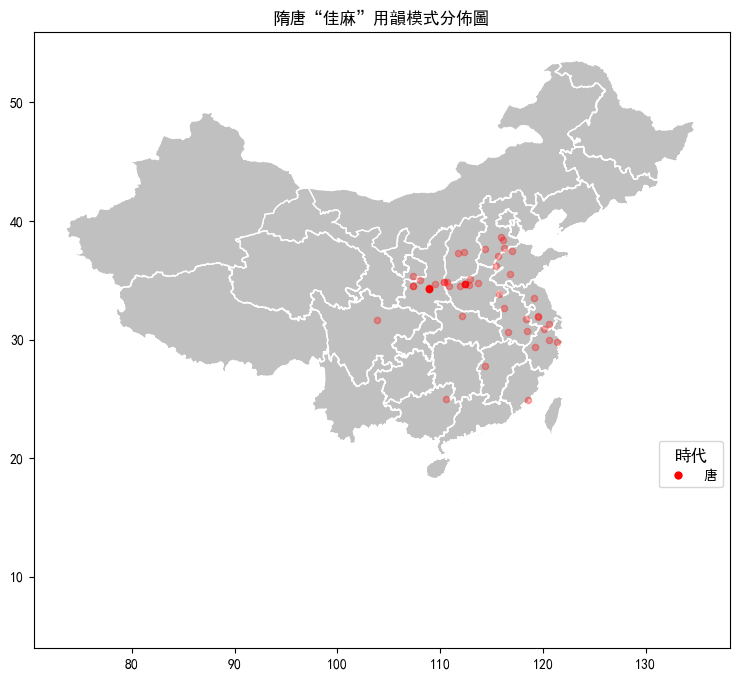

In [2]:
plot_map(r'F:\古籍處理數據\output\隋唐\規則\規則-詩人-坐標\佳麻-坐標.xlsx', save_image=False)

# 創建適合導入neo4j的csv文件

In [62]:
# 篩選符合指定規則的詩歌並保存
rules_df = pd.read_excel(r'F:\古籍處理數據\output\規則\總規則（已人工篩選）.xlsx')
rules_df['antecedents'] = rules_df['antecedents'].apply(eval)
rules_df['consequents'] = rules_df['consequents'].apply(eval)
rules_df['antecedents'] = rules_df['antecedents'].map(list)
rules_df['consequents'] = rules_df['consequents'].map(list)

rhyme1_list = []
rhyme2_list = []
for i,row in rules_df.iterrows():
    rhyme1 = row['antecedents']
    rhyme1_list += rhyme1
    rhyme2 = row['consequents']
    rhyme2_list += rhyme2
rhymes = list(set(rhyme1_list + rhyme2_list))

rhyme_df = pd.DataFrame({'rhyme':rhymes})
rels_df = pd.DataFrame({'from':rhyme1_list, 'to':rhyme2_list})

In [63]:
rhyme_df.to_csv(r'F:\古籍處理數據\output\規則\rhyme.csv', encoding='utf-8', index=False)
rels_df.to_csv(r'F:\古籍處理數據\output\規則\rels.csv', encoding='utf-8', index=False)

In [ ]:
# 導入neo4j的代碼：

# 1.首先導入節點：
# LOAD CSV WITH HEADERS FROM 'file:///rhyme.csv' AS line
# MERGE (:Rhyme {rhyme: line.rhyme})

# 2.其次導入關係：
# LOAD CSV WITH HEADERS FROM 'file:///rels.csv' AS line
# MATCH (r1:Rhyme {rhyme: line.from}), (r2:Rhyme {rhyme: line.to})
# MERGE (r1)-[:混入]->(r2)